In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
)

def fetch_data(fname='wine.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES = [
    'Label',
    'Alcohol',
    'Malic Acid',
    'Ash',
    'Alcalinity of Ash',
    'Magnesium',
    'Total Phenols',
    'Flavanoids',
    'Nonflavanoid Phenols',
    'Proanthocyanins',
    'Color Intensity',
    'Hue',
    'OD280/OD315 of Diluted Wines',
    'Proline',
]

LABEL_MAPS = {
    1: "Class 1",
    2: "Class 2",
    3: "Class 3",
}

# Read the data into a DataFrame
df = pd.read_csv(DATA, sep=',', header=None, names=FEATURES)

# Convert class labels into text
for k,v in LABEL_MAPS.items():
    df.ix[df.Label == k, 'Label'] = v

print(df.describe())

          Alcohol  Malic Acid         Ash  Alcalinity of Ash   Magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

In [4]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(df.groupby('Label')['Label'].count())

178 instances with 14 features

Label
Class 1    59
Class 2    71
Class 3    48
Name: Label, dtype: int64


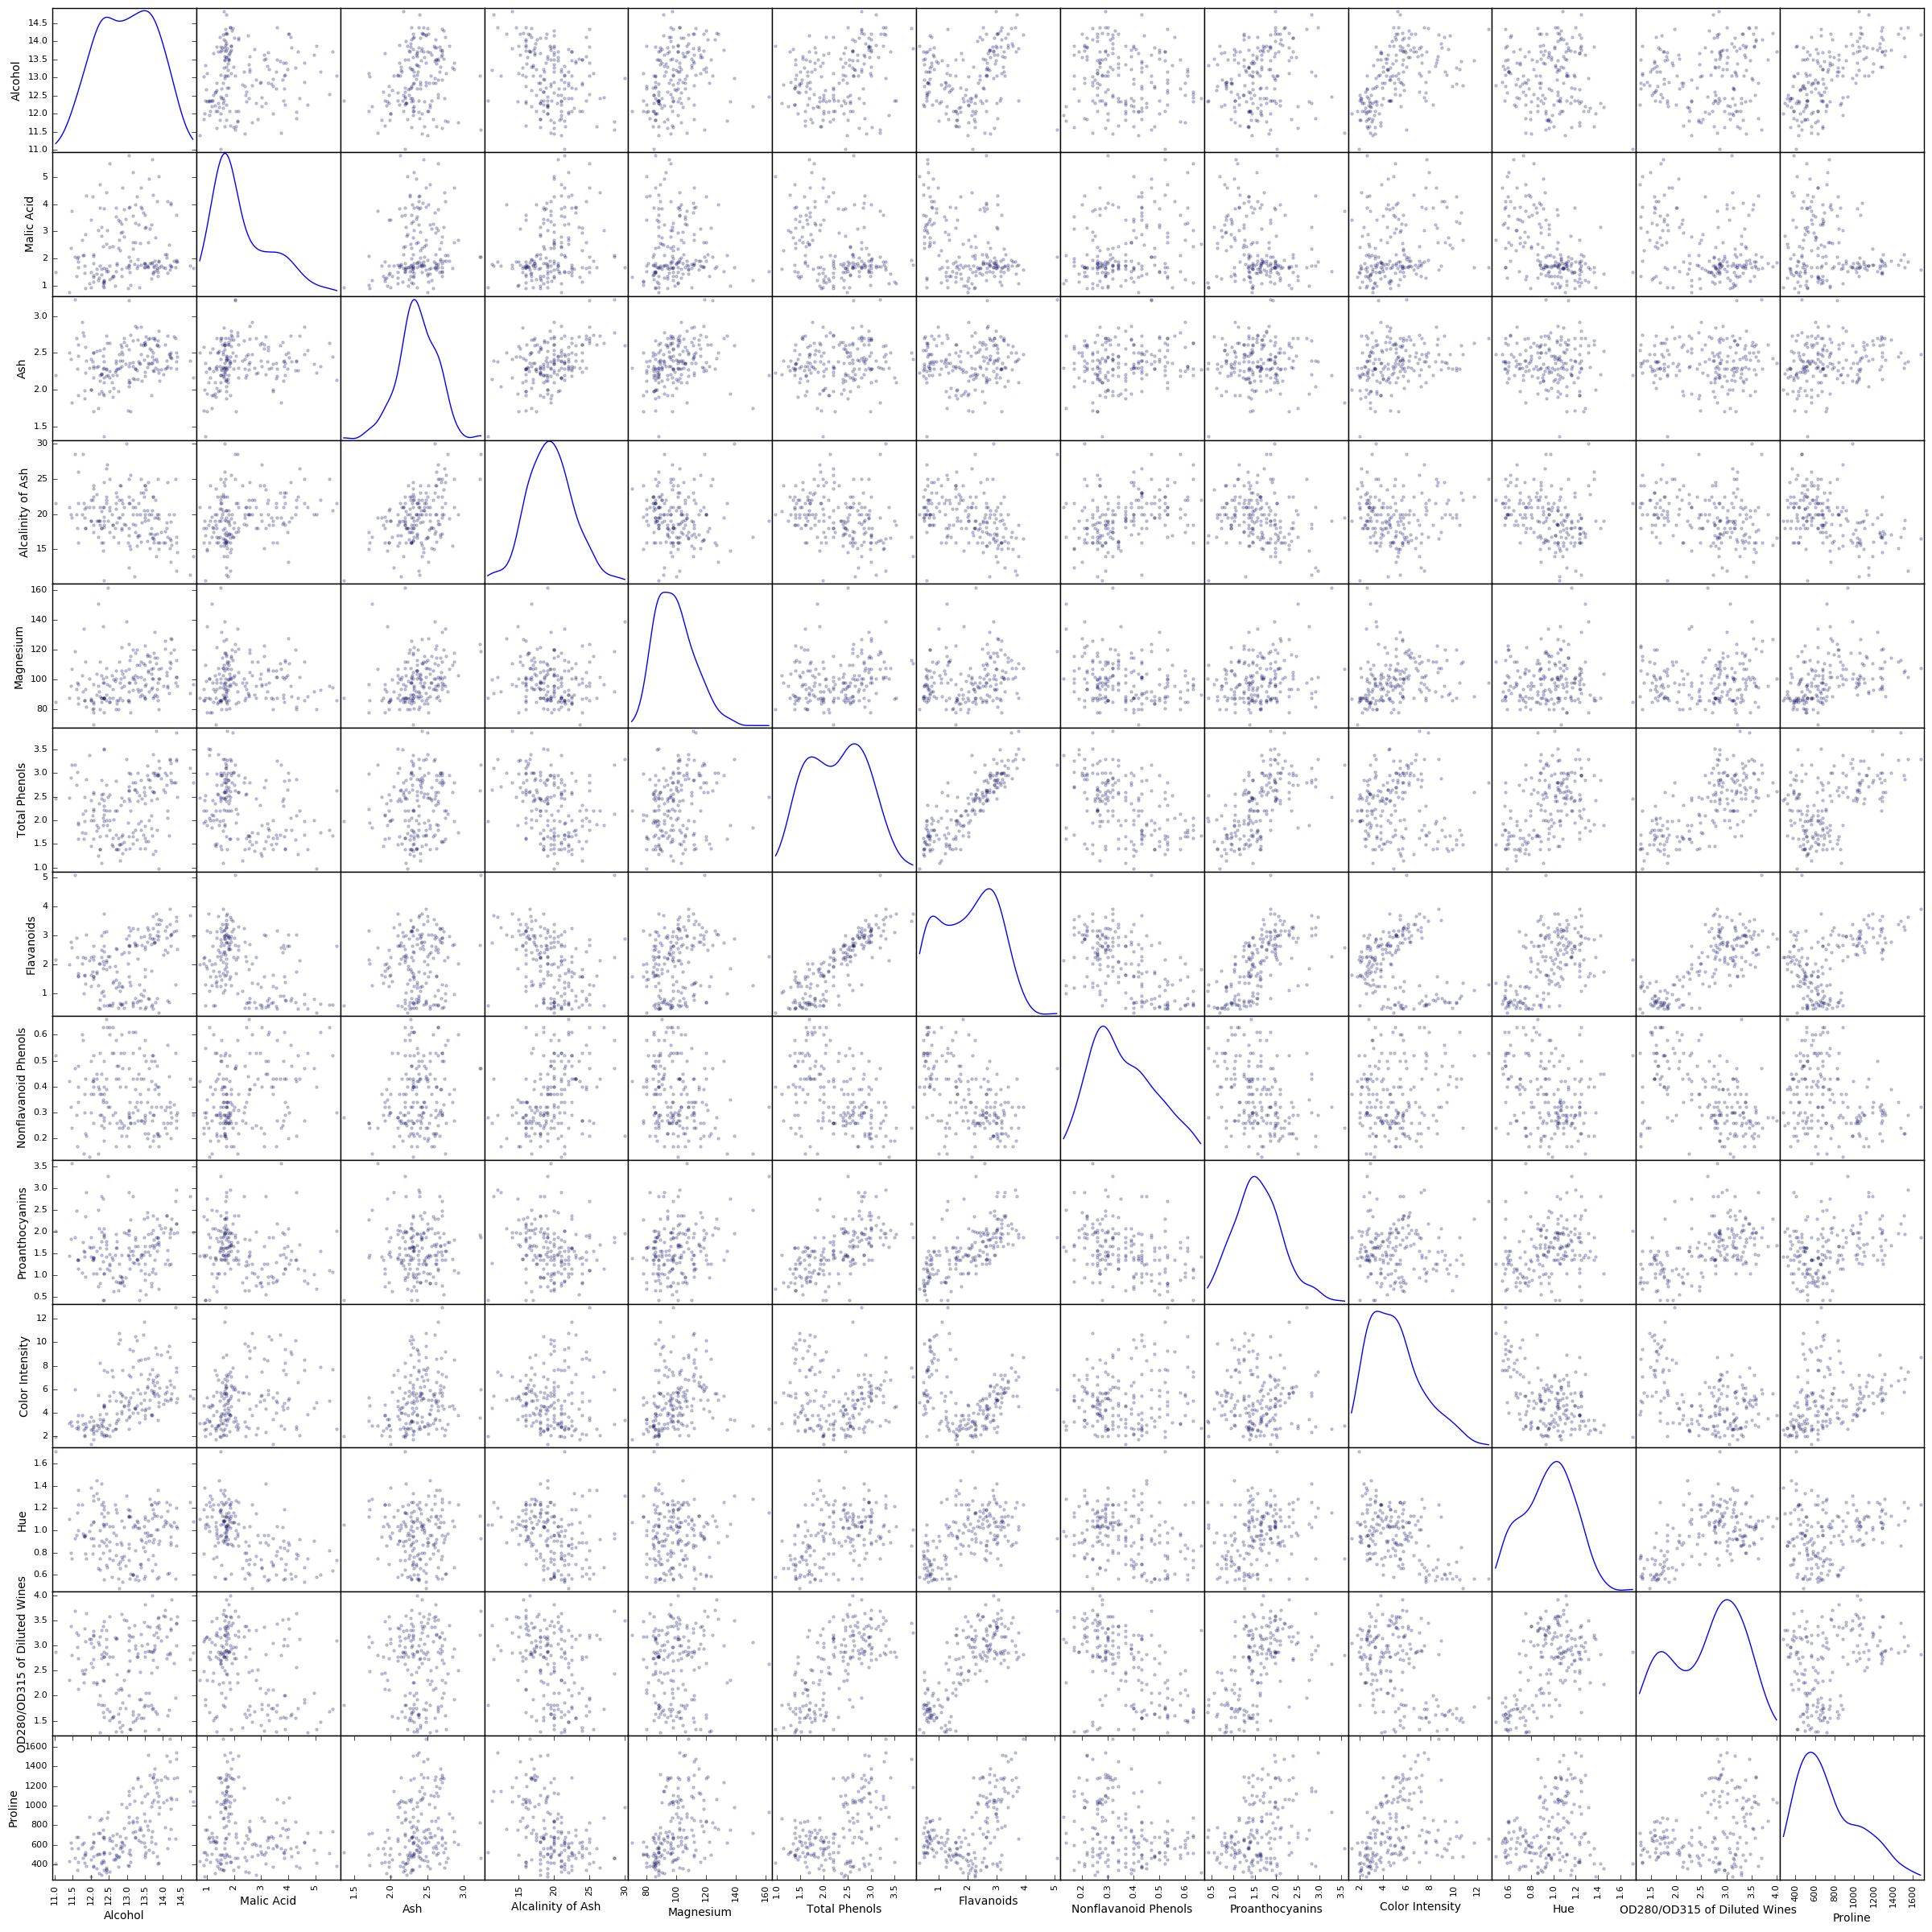

In [5]:
# Create a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()

In [6]:
print(df.head())

     Label  Alcohol  Malic Acid   Ash  Alcalinity of Ash  Magnesium  \
0  Class 1    14.23        1.71  2.43               15.6        127   
1  Class 1    13.20        1.78  2.14               11.2        100   
2  Class 1    13.16        2.36  2.67               18.6        101   
3  Class 1    14.37        1.95  2.50               16.8        113   
4  Class 1    13.24        2.59  2.87               21.0        118   

   Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color Intensity   Hue  OD280/OD315 of Diluted Wines  Proline  
0             5.64  1.04                          3.92     1065  
1             

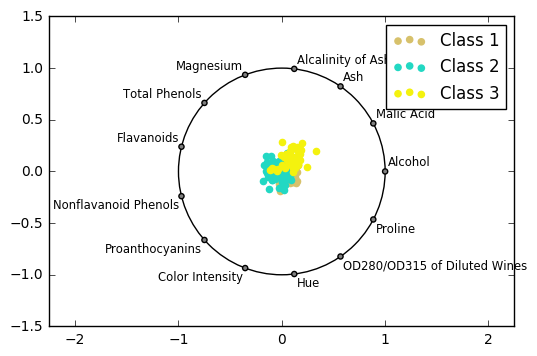

In [7]:
from pandas.tools.plotting import radviz
plt.figure()
radviz(df, 'Label')

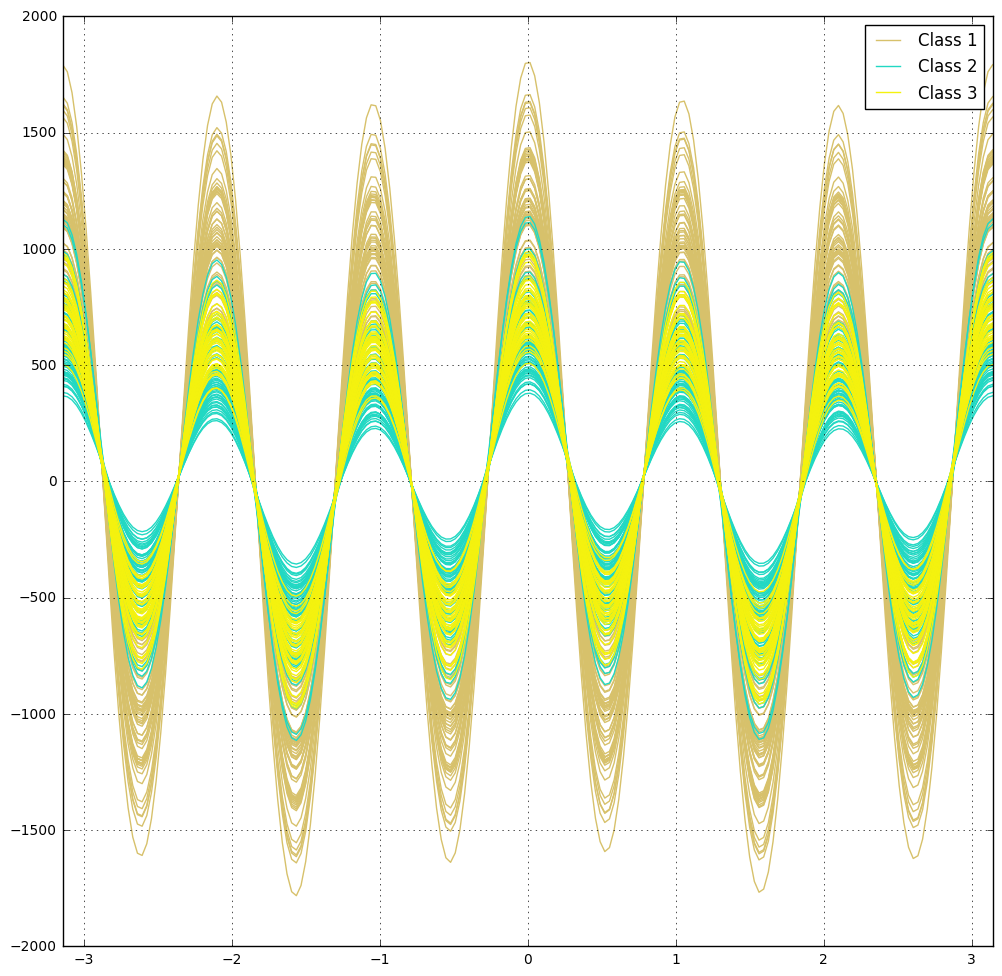

In [8]:
from pandas.tools.plotting import andrews_curves
plt.figure(figsize=(12,12))
andrews_curves(df, 'Label')

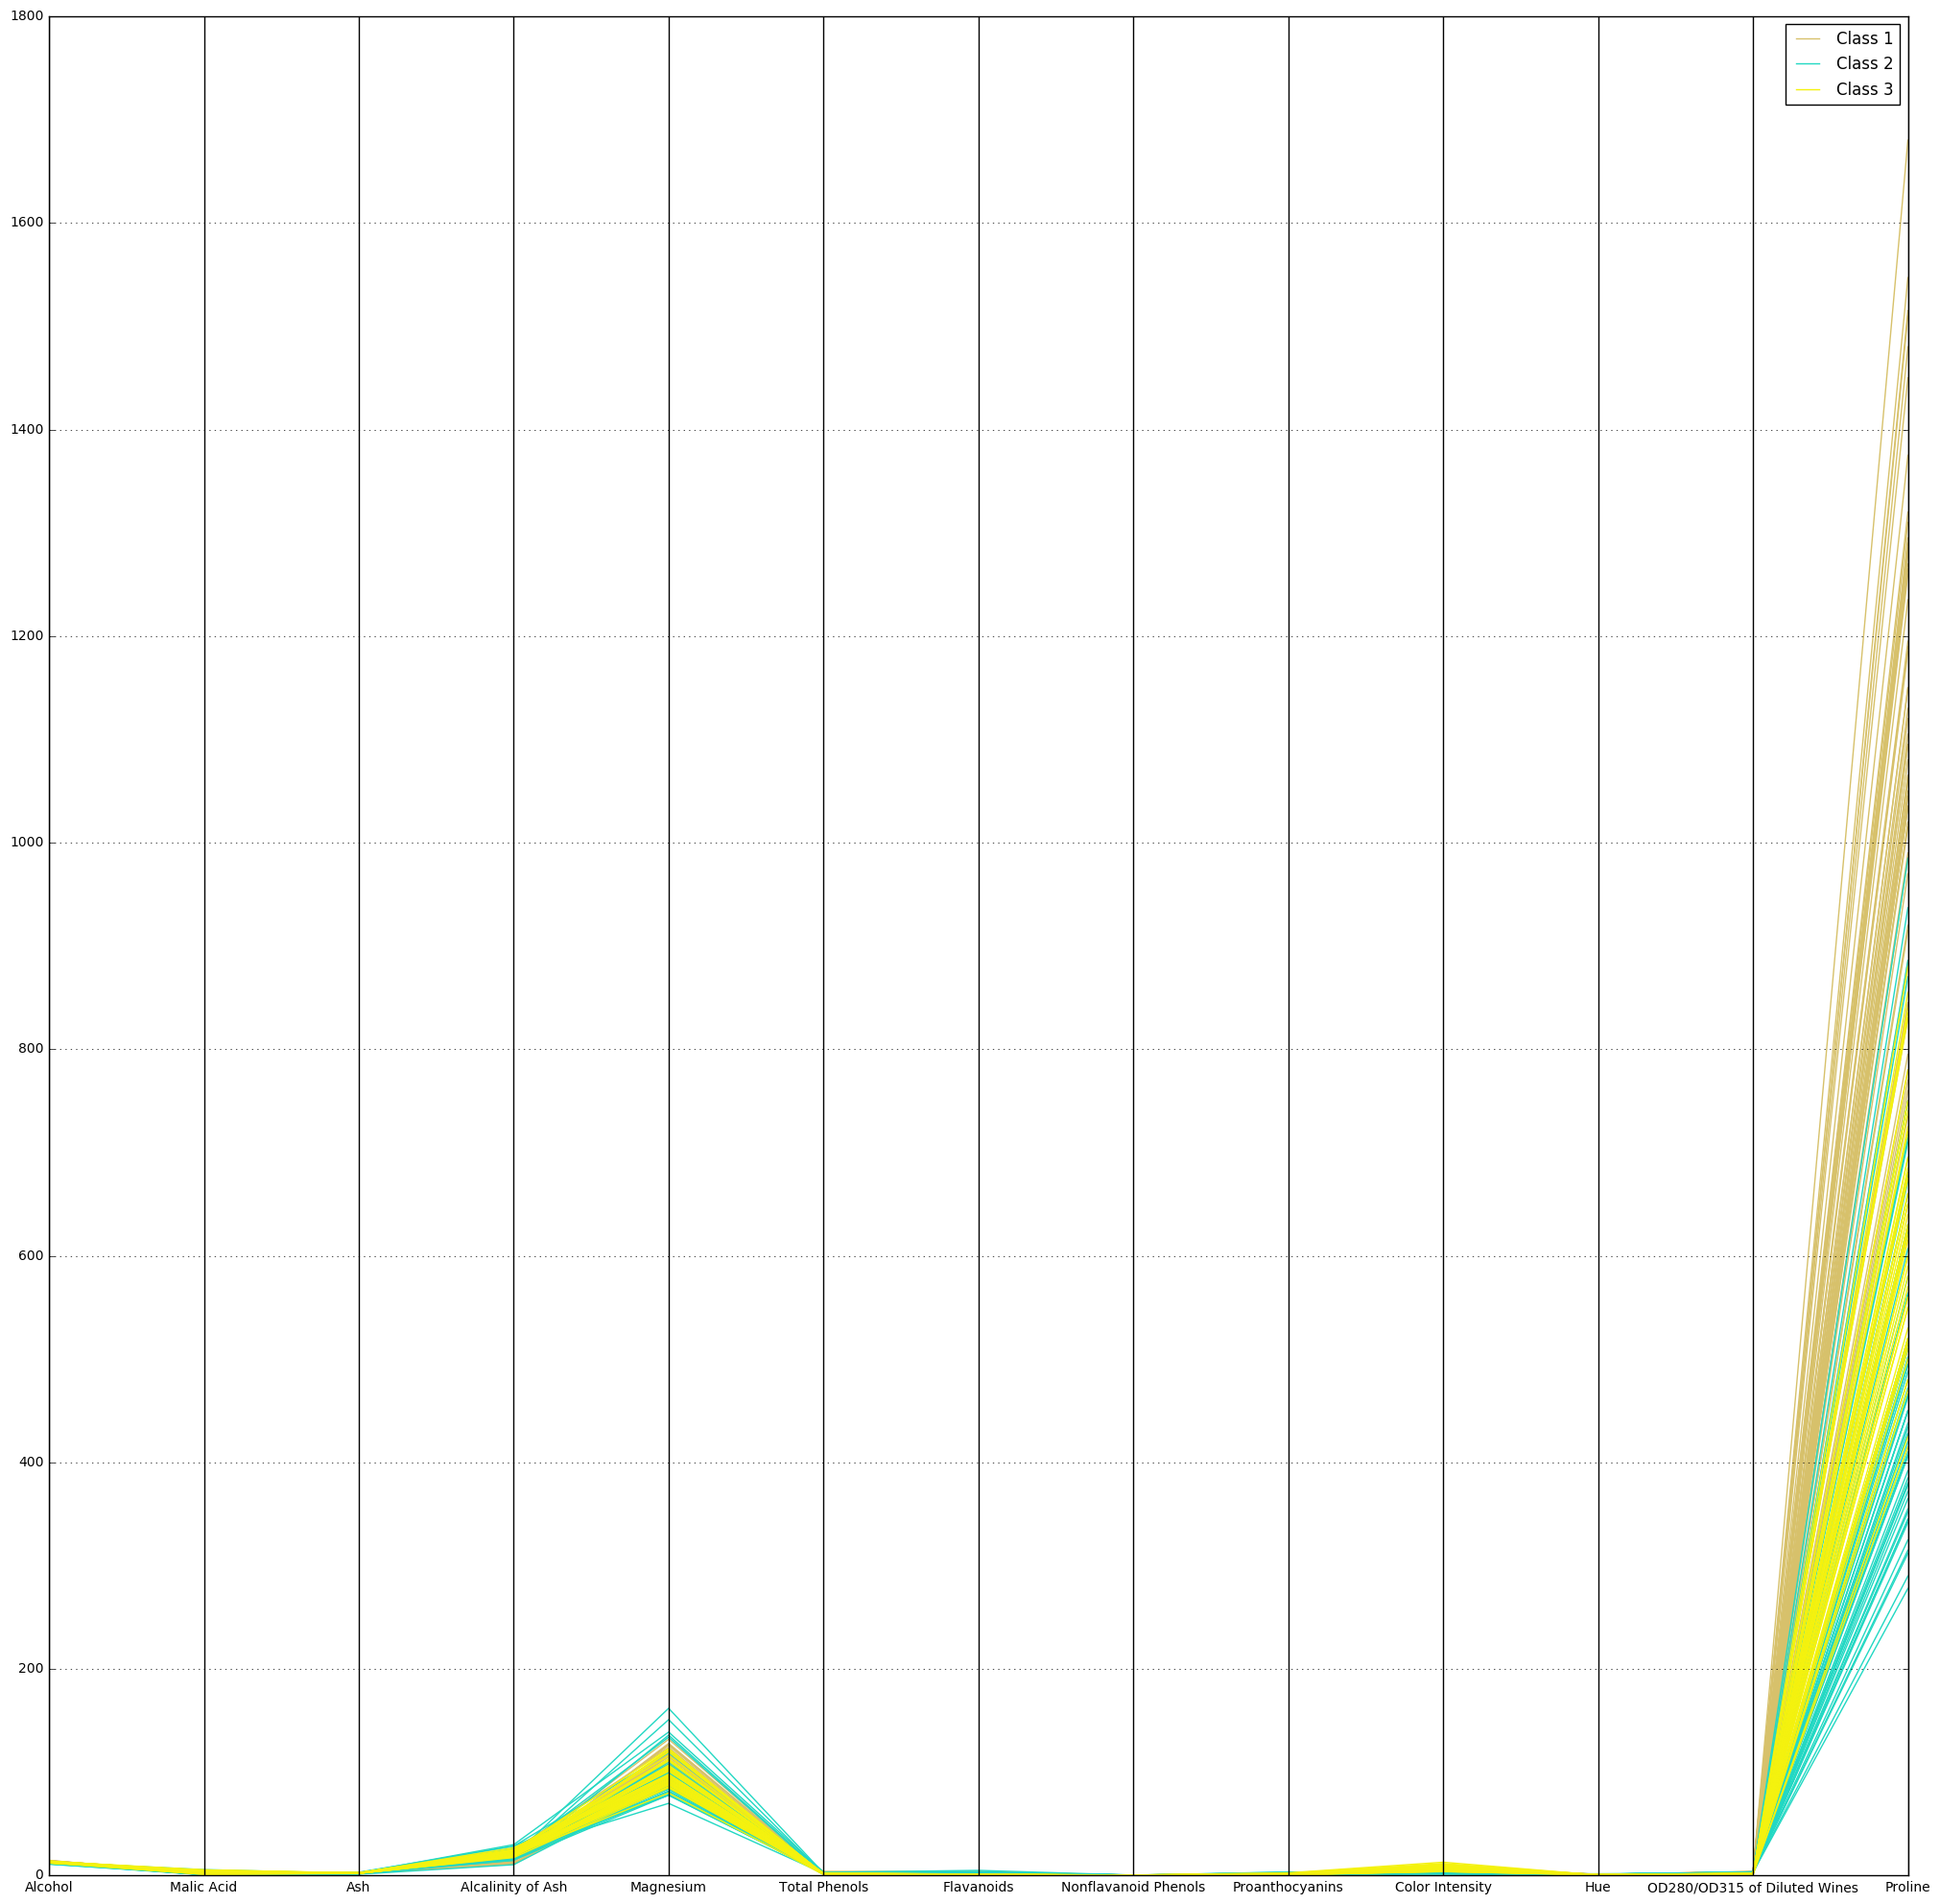

In [9]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(25,25))
parallel_coordinates(df, 'Label')

In [10]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "data", "wine"))

# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print("- {}".format(name))

- dataset.csv
- meta.json
- README.md
- wine.txt
- wrangle.py


In [12]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'wine.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter=',')

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(178, 13)
(178,)


In [13]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [14]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "Wine Cultivar - SVM Classifier")

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Build and Validation of Wine Cultivar - SVM Classifier took 0.478 seconds
Validation scores are as follows:

accuracy     0.005556
f1           0.003704
precision    0.002778
recall       0.005556
dtype: float64

Fitted model written to:
/Users/djbarnhar/Desktop/GTown_Git_Labs/machine-learning/wine_dataset/wine-cultivar---svm-classifier.pickle


In [15]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Wine Cultivar kNN Classifier", n_neighbors=12)

Build and Validation of Wine Cultivar kNN Classifier took 0.050 seconds
Validation scores are as follows:

accuracy     0.0
f1           0.0
precision    0.0
recall       0.0
dtype: float64

Fitted model written to:
/Users/djbarnhar/Desktop/GTown_Git_Labs/machine-learning/wine_dataset/wine-cultivar-knn-classifier.pickle


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Wine Cultivar - Random Forest Classifier")

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning

Build and Validation of Wine Cultivar - Random Forest Classifier took 0.392 seconds
Validation scores are as follows:

accuracy     0.005952
f1           0.005952
precision    0.005952
recall       0.005952
dtype: float64

Fitted model written to:
/Users/djbarnhar/Desktop/GTown_Git_Labs/machine-learning/wine_dataset/wine-cultivar---random-forest-classifier.pickle


In [17]:
# Perform LinearDiscriminantAnalysis
fit_and_evaluate(dataset, LinearDiscriminantAnalysis, "Wine Cultivar - LDA")

Build and Validation of Wine Cultivar - LDA took 0.155 seconds
Validation scores are as follows:

accuracy     0.011111
f1           0.011111
precision    0.011111
recall       0.011111
dtype: float64

Fitted model written to:
/Users/djbarnhar/Desktop/GTown_Git_Labs/machine-learning/wine_dataset/wine-cultivar---lda.pickle


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true sa

In [18]:
# Perform QuadraticDiscriminantAnalysis
fit_and_evaluate(dataset, QuadraticDiscriminantAnalysis, "Wine Cultivar - QDA")

ValueError: y has only 1 sample in class 278.0, covariance is ill defined.